**Below I will be building and optimizing a k-NN model to predict diabetes occurrences using the Pima Indian Diabetes dataset from kaggle:**

---



https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
from google.colab import files 
upload = files.upload()

import io 
import pandas as pd
df = pd.read_csv(io.BytesIO(upload['diabetes.csv']))

Saving diabetes.csv to diabetes.csv


**Assesing Target Variable Distribution**

---



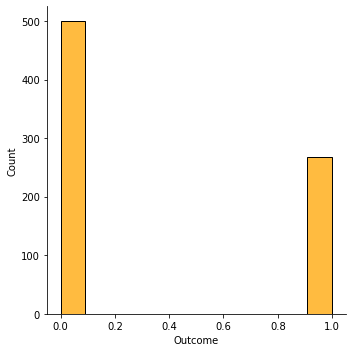

In [3]:
sns.displot(df['Outcome'], color= 'orange')

**Further exploring distribution and information value of individual features using a pairplot**

---



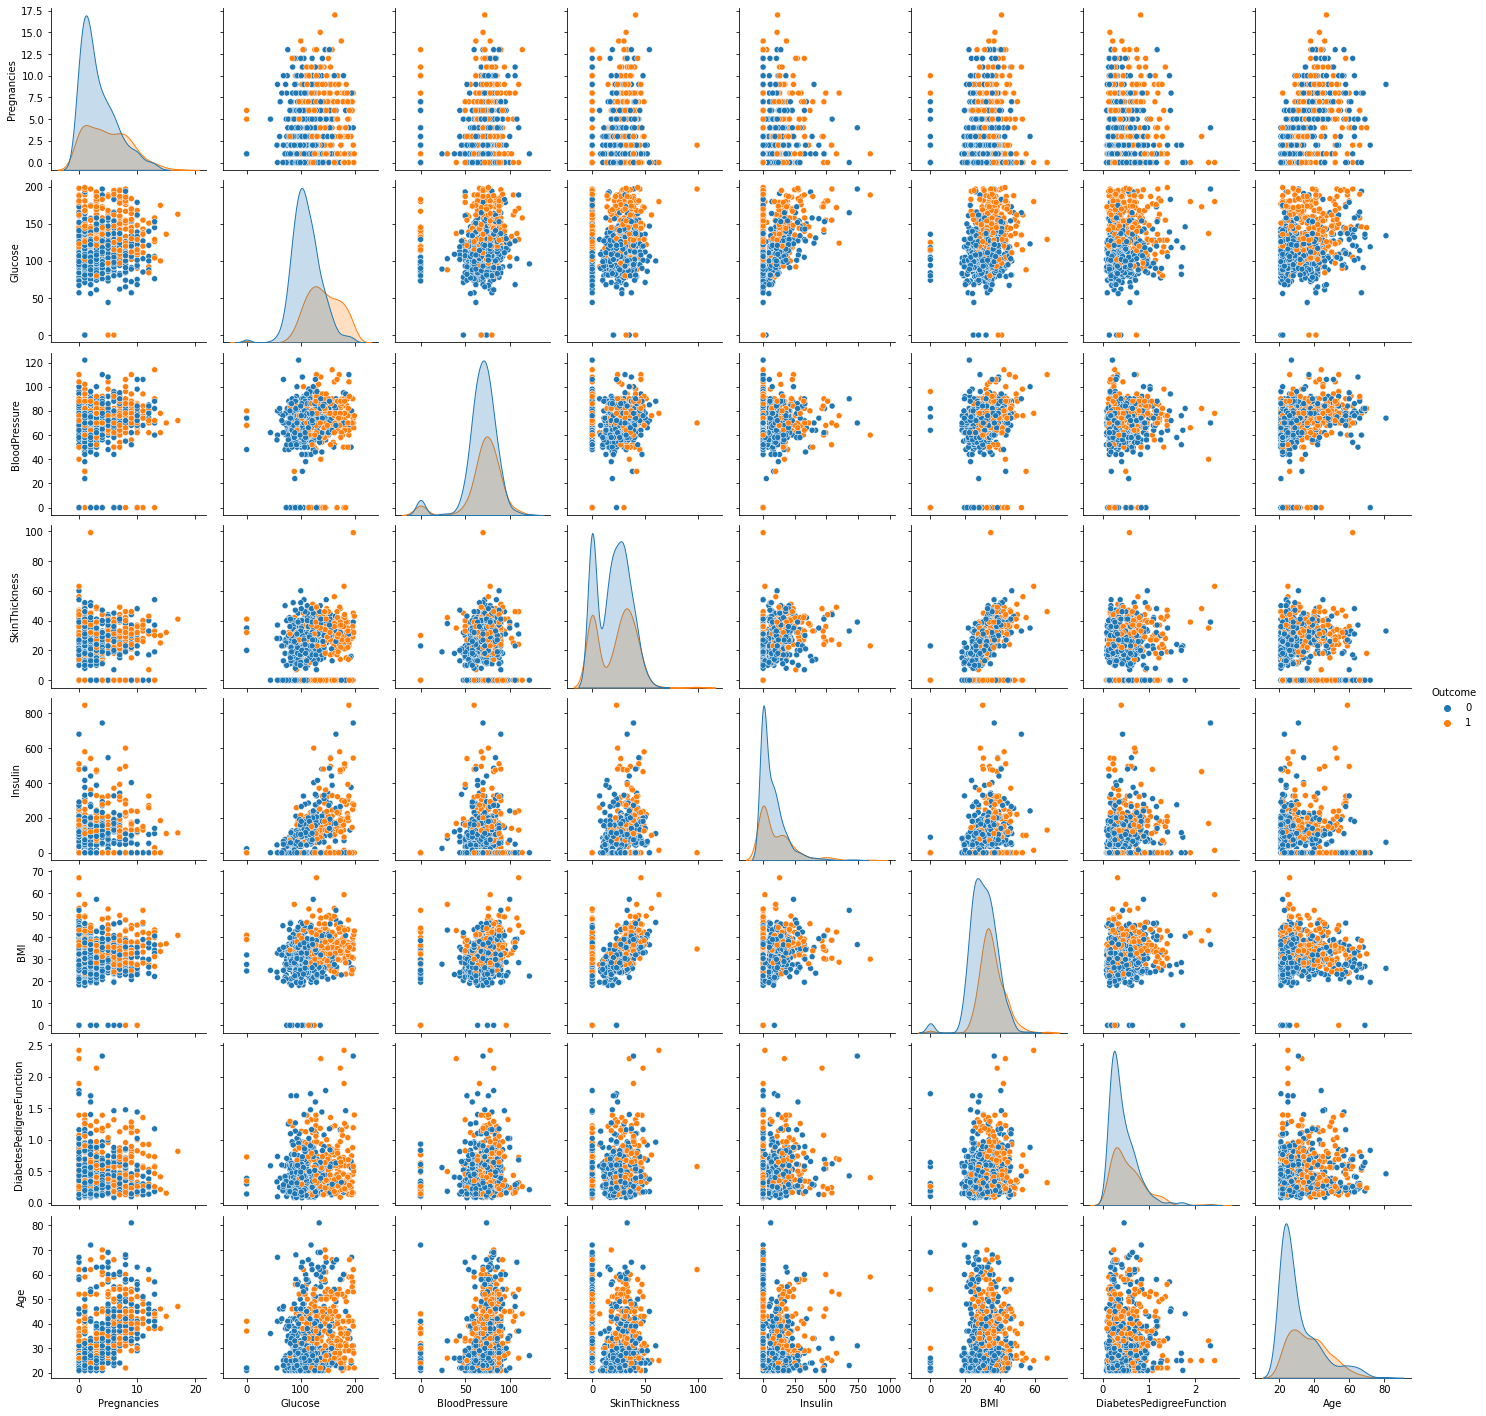

In [ ]:
sns.pairplot(df, hue= 'Outcome')

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
df.drop(df[df['Glucose'] == 0 ].index, inplace=True)
df.drop(df[df['BloodPressure'] == 0 ].index, inplace=True)
df.drop(df[df['BMI'] == 0 ].index, inplace=True)
df.drop(df[df['Insulin'] == 0 ].index, inplace=True)
df.drop(df[df['SkinThickness'] == 0 ].index, inplace=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,392.0,3.301020,3.211424,0.000,1.00000,2.0000,5.000,17.00
Glucose,392.0,122.627551,30.860781,56.000,99.00000,119.0000,143.000,198.00
BloodPressure,392.0,70.663265,12.496092,24.000,62.00000,70.0000,78.000,110.00
SkinThickness,392.0,29.145408,10.516424,7.000,21.00000,29.0000,37.000,63.00
Insulin,392.0,156.056122,118.841690,14.000,76.75000,125.5000,190.000,846.00
BMI,392.0,33.086224,7.027659,18.200,28.40000,33.2000,37.100,67.10
DiabetesPedigreeFunction,392.0,0.523046,0.345488,0.085,0.26975,0.4495,0.687,2.42
Age,392.0,30.864796,10.200777,21.000,23.00000,27.0000,36.000,81.00
Outcome,392.0,0.331633,0.471401,0.000,0.00000,0.0000,1.000,1.00


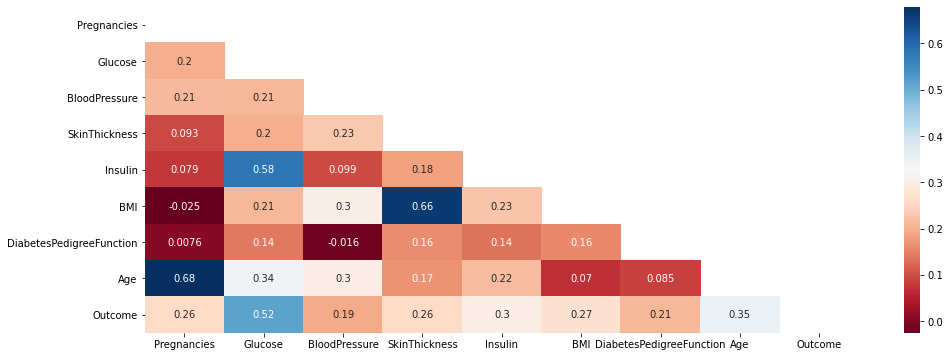

In [36]:
plt.figure(figsize=(16, 6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='RdBu')

**Scaling data prior to building k-NN model**

---



In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_mm = scaler.fit_transform(df)

X_rescaled = pd.DataFrame(X_train_mm, columns=df.columns)

In [8]:
X_rescaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.058824,0.232394,0.488372,0.285714,0.096154,0.202454,0.035118,0.000000,0.0
1,0.000000,0.570423,0.186047,0.500000,0.185096,0.509202,0.943469,0.200000,1.0
2,0.176471,0.154930,0.302326,0.446429,0.088942,0.261759,0.069807,0.083333,1.0
3,0.117647,0.992958,0.534884,0.678571,0.635817,0.251534,0.031263,0.533333,1.0
4,0.058824,0.936620,0.418605,0.285714,1.000000,0.243354,0.134047,0.633333,1.0


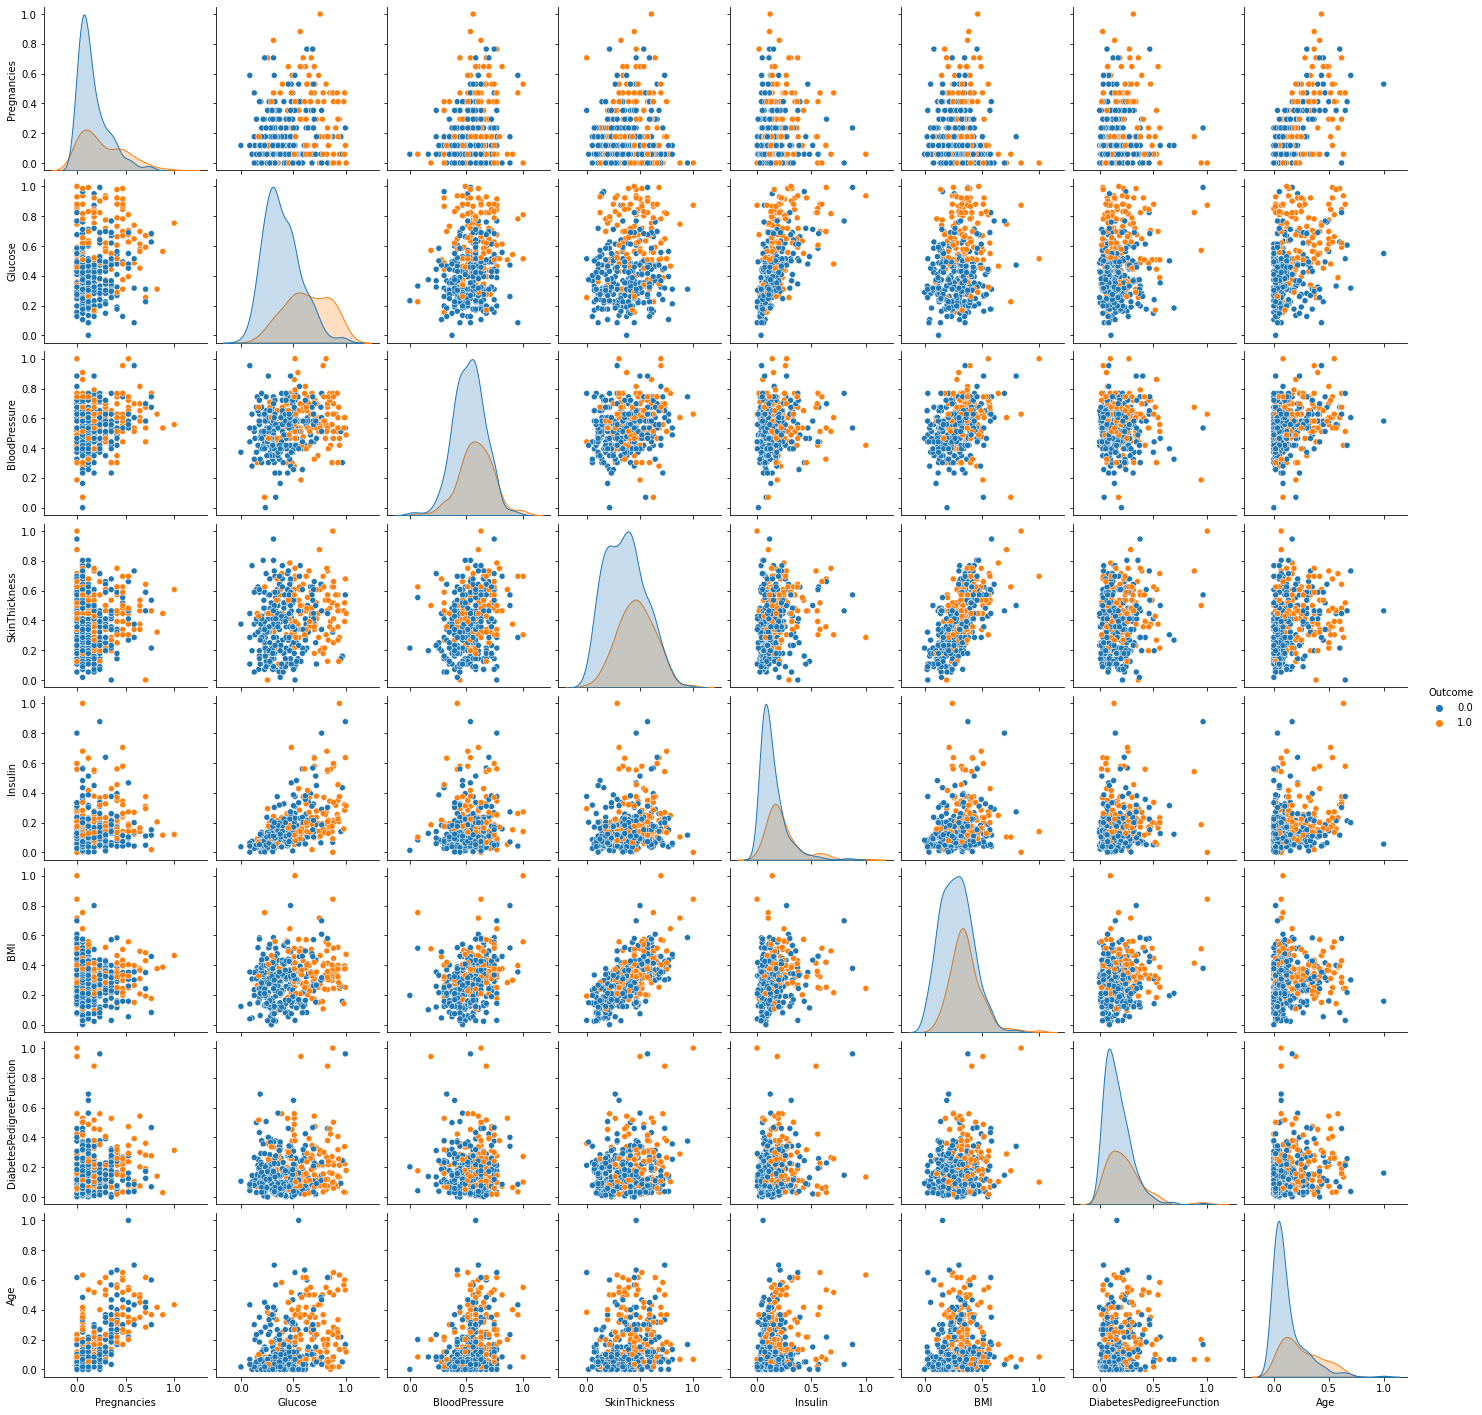

In [9]:
sns.pairplot(X_rescaled, hue= 'Outcome')

In [10]:
X = X_rescaled.drop('Outcome', axis= 1)
y = X_rescaled['Outcome']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**Building k-NN model and determining the optimal value of k based on the ROC AUC**
---

In [12]:
knn = KNeighborsClassifier(n_neighbors= 5,  metric= 'euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[64 18]
 [12 24]]
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81        82
         1.0       0.57      0.67      0.62        36

    accuracy                           0.75       118
   macro avg       0.71      0.72      0.71       118
weighted avg       0.76      0.75      0.75       118



In [13]:
from sklearn.metrics import roc_auc_score

print('ROC AUC: ', roc_auc_score(y_test,y_pred))

ROC AUC:  0.7235772357723577


In [14]:
from sklearn.model_selection import cross_val_score
max_K = 100
cv_scores = [ ]

for K in range(1,max_K):
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X_train,y_train.values.ravel(),cv = 5,scoring = "roc_auc")
    cv_scores.append(scores.mean())

In [15]:
print('ROC AUC:', max(cv_scores)) #prints highest roc auc score in list of k values

ROC AUC: 0.8628248862897985


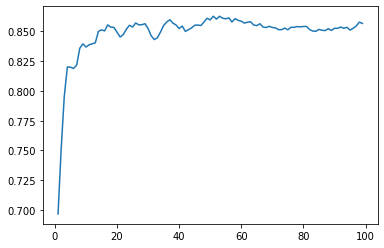

In [16]:
sns.lineplot(x= range(1,max_K), y= cv_scores)

The most optimal and stable value of k lies between around the 40s based on the lineplot above, moving forward the optimal value we will be using in our model is k = 41 to avoid any ties.

**Comparing the optimized kNN model performance versus a logistic regression model across the following metrics: Recall, Precision, F1, ROC AUC. Based on each metric we will choose the ideal model**

---



In [17]:
from sklearn.linear_model import LogisticRegression
f2 = pd.read_csv(io.BytesIO(upload['diabetes.csv']))

In [18]:
f2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
df2 = f2.drop(['BMI', 'DiabetesPedigreeFunction','Age','SkinThickness'],axis=1)

In [20]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.0,1.0,3.0,6.00,17.0
Glucose,768.0,120.894531,31.972618,0.0,99.0,117.0,140.25,199.0
BloodPressure,768.0,69.105469,19.355807,0.0,62.0,72.0,80.00,122.0
Insulin,768.0,79.799479,115.244002,0.0,0.0,30.5,127.25,846.0
Outcome,768.0,0.348958,0.476951,0.0,0.0,0.0,1.00,1.0


In [21]:
df2.drop(df2[df2['Glucose'] == 0 ].index, inplace=True)
df2.drop(df2[df2['BloodPressure'] == 0 ].index, inplace=True)
df2.drop(df2[df2['Insulin'] == 0 ].index, inplace=True)

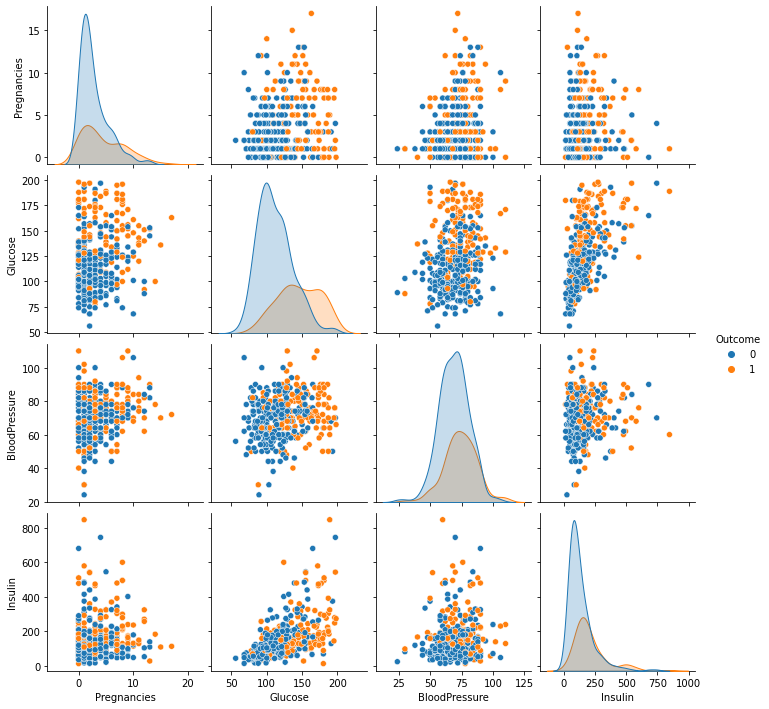

In [22]:
sns.pairplot(df2, hue= 'Outcome')

In [23]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,393.0,3.292621,3.211645,0.0,1.0,2.0,5.0,17.0
Glucose,393.0,122.615776,30.822276,56.0,99.0,119.0,143.0,198.0
BloodPressure,393.0,70.646310,12.484668,24.0,62.0,70.0,78.0,110.0
Insulin,393.0,155.885496,118.738199,14.0,77.0,125.0,190.0,846.0
Outcome,393.0,0.330789,0.471097,0.0,0.0,0.0,1.0,1.0


In [24]:
X2 = df2.drop('Outcome', axis=1)
y2 = df2['Outcome']

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [26]:
diabetes_log = LogisticRegression(solver='liblinear')

diabetes_log.fit(train_X,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
log_pred = diabetes_log.predict(test_X)

In [28]:
confusion_matrix(test_y,log_pred) 

array([[66, 18],
       [17, 17]])

In [29]:
#metrics for logistic model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

print("ROC AUC:" ,roc_auc_score(test_y, log_pred))
print("Accuracy:",metrics.accuracy_score(test_y, log_pred))
print("Recall:",metrics.recall_score(test_y, log_pred))
print("Precision:",metrics.precision_score(test_y, log_pred))

ROC AUC: 0.6428571428571429
Accuracy: 0.7033898305084746
Recall: 0.5
Precision: 0.4857142857142857


In [30]:
print(classification_report(test_y,log_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79        84
           1       0.49      0.50      0.49        34

    accuracy                           0.70       118
   macro avg       0.64      0.64      0.64       118
weighted avg       0.71      0.70      0.70       118



In [32]:
# kNN with k = 41 

knn = KNeighborsClassifier(n_neighbors= 41,  metric= 'euclidean')
knn.fit(X_train, y_train)

optimal_K = knn.predict(X_test)

In [33]:
print(classification_report(y_test,optimal_K))

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85        82
         1.0       0.68      0.47      0.56        36

    accuracy                           0.77       118
   macro avg       0.74      0.69      0.70       118
weighted avg       0.76      0.77      0.76       118



In [34]:
#metrics for kNN model — using y_test and our optimal kNN value of k = 40
print("ROC AUC:" ,roc_auc_score(y_test, optimal_K))
print("Accuracy:",metrics.accuracy_score(y_test, optimal_K))
print("Recall:",metrics.recall_score(y_test, optimal_K))
print("Precision:",metrics.precision_score(y_test, optimal_K))

ROC AUC: 0.6873306233062331
Accuracy: 0.7711864406779662
Recall: 0.4722222222222222
Precision: 0.68


**Based on the metrics above for the k-NN and logistic regression model, the ideal model for this dataset would be the kNN model due to its accuracy and precision surprassing the metrics of the logistic regression model**
